# **Laboratorio 8 | Detección de Anomalías con Autoencoder, Isolation Forest y LOF**

- Diego Duarte
- Paula Barillas 

### Librerias

In [1]:
from sklearn.datasets import fetch_covtype
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

### Carga de datos

In [2]:
data = fetch_covtype(as_frame=True)
X = data['data']
y = data['target']

print(X.shape, y.shape)

(581012, 54) (581012,)


In [3]:
num_features = ['Elevation','Aspect','Slope',
                'Horizontal_Distance_To_Hydrology',
                'Vertical_Distance_To_Hydrology',
                'Horizontal_Distance_To_Roadways',
                'Hillshade_9am','Hillshade_Noon','Hillshade_3pm',
                'Horizontal_Distance_To_Fire_Points']

bin_features = [col for col in X.columns if col not in num_features]

In [12]:
scaler = StandardScaler()
X_scaled = X.copy()
X_scaled[num_features] = scaler.fit_transform(X[num_features])
X_scaled[bin_features] = X_scaled[bin_features].astype(float) 

In [13]:
print("\nVariables numéricas (10):")
print(num_features)

print("\nVariables binarias (44):")
print(bin_features[:10], "...")  


print("\n--- Estadísticas descriptivas (numéricas) ---")
print(X[num_features].describe())


print("\n--- Distribución de variables binarias ---")
bin_summary = X[bin_features].sum().sort_values(ascending=False)
print(bin_summary.head(10))  


print("\n--- Distribución Cover_Type ---")
print(y.value_counts(normalize=True) * 100)


Variables numéricas (10):
['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points']

Variables binarias (44):
['Wilderness_Area_0', 'Wilderness_Area_1', 'Wilderness_Area_2', 'Wilderness_Area_3', 'Soil_Type_0', 'Soil_Type_1', 'Soil_Type_2', 'Soil_Type_3', 'Soil_Type_4', 'Soil_Type_5'] ...

--- Estadísticas descriptivas (numéricas) ---
           Elevation         Aspect          Slope  \
count  581012.000000  581012.000000  581012.000000   
mean     2959.365301     155.656807      14.103704   
std       279.984734     111.913721       7.488242   
min      1859.000000       0.000000       0.000000   
25%      2809.000000      58.000000       9.000000   
50%      2996.000000     127.000000      13.000000   
75%      3163.000000     260.000000      18.000000   
max      3858.000000     360.000000      66.000000   

      

### Descripcion de las variables

- Elevation: Altitud en metros (min ~1850, max ~3858).
- Aspect: Orientación (0–360°).
- Slope: Inclinación (0–60°).
- Hillshade_xx: Índices de sombra según hora (0–255).
- Distancias horizontales/verticales: Hasta agua, caminos, fuego.
- Wilderness_Area (4 cols): Variables dummy, solo una activa por observación.
- Soil_Type (40 cols): Variables dummy, solo una activa.
- Cover_Type (y): Clases 1–7 (muy desbalanceadas, Lodgepole Pine ≈ 49% de los datos).

### Etiquetar datos

In [14]:
y_binary = (y == 2).astype(int)  

print("Distribución normal(1) vs anómalo(0):")
print(y_binary.value_counts())
print("\nPorcentajes:")
print(y_binary.value_counts(normalize=True) * 100)

X_labeled = X.copy()
X_labeled['AnomalyLabel'] = y_binary

X_labeled.head()

Distribución normal(1) vs anómalo(0):
Cover_Type
0    297711
1    283301
Name: count, dtype: int64

Porcentajes:
Cover_Type
0    51.240078
1    48.759922
Name: proportion, dtype: float64


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,AnomalyLabel
0,2596.0,51.0,3.0,258.0,0.0,510.0,221.0,232.0,148.0,6279.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,2590.0,56.0,2.0,212.0,-6.0,390.0,220.0,235.0,151.0,6225.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,2804.0,139.0,9.0,268.0,65.0,3180.0,234.0,238.0,135.0,6121.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,2785.0,155.0,18.0,242.0,118.0,3090.0,238.0,238.0,122.0,6211.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,2595.0,45.0,2.0,153.0,-1.0,391.0,220.0,234.0,150.0,6172.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


### Test/Train/Val

In [15]:

#  PIPELINE 1: Para Autoencoder (train/val solo normales)
# Filtrar solo normales
X_normal = X[y_binary == 1]

# Train/Validation solo normales
X_train_ae, X_val_ae = train_test_split(
    X_normal, test_size=0.2, random_state=42
)

X_test_ae = X
y_test_ae = y_binary

print("=== Autoencoder Split ===")
print("Train (solo normales):", X_train_ae.shape)
print("Validation (solo normales):", X_val_ae.shape)
print("Test (mezcla):", X_test_ae.shape, y_test_ae.shape)
print("Distribución en Test:\n", y_test_ae.value_counts(normalize=True) * 100)


# PIPELINE 2: Para Isolation Forest y LOF (train/test con mezcla)

X_train_iso, X_test_iso, y_train_iso, y_test_iso = train_test_split(
    X, y_binary, test_size=0.2, random_state=42, stratify=y_binary
)

print("\n=== Isolation Forest / LOF Split ===")
print("Train (mezcla):", X_train_iso.shape, y_train_iso.shape)
print("Test (mezcla):", X_test_iso.shape, y_test_iso.shape)
print("Distribución en Train:\n", y_train_iso.value_counts(normalize=True) * 100)
print("Distribución en Test:\n", y_test_iso.value_counts(normalize=True) * 100)

=== Autoencoder Split ===
Train (solo normales): (226640, 54)
Validation (solo normales): (56661, 54)
Test (mezcla): (581012, 54) (581012,)
Distribución en Test:
 Cover_Type
0    51.240078
1    48.759922
Name: proportion, dtype: float64

=== Isolation Forest / LOF Split ===
Train (mezcla): (464809, 54) (464809,)
Test (mezcla): (116203, 54) (116203,)
Distribución en Train:
 Cover_Type
0    51.239972
1    48.760028
Name: proportion, dtype: float64
Distribución en Test:
 Cover_Type
0    51.240502
1    48.759498
Name: proportion, dtype: float64


### Autoencoder

In [16]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential, callbacks

input_dim = X_train_ae.shape[1]

autoencoder = Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(64, activation="relu"),
    layers.Dense(32, activation="relu"),
    layers.Dense(16, activation="relu"),  # bottleneck
    layers.Dense(32, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(input_dim, activation="linear")
])

autoencoder.compile(optimizer="adam", loss="mse")

early_stop = callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# Entrenamiento solo con normales
history_ae = autoencoder.fit(
    X_train_ae, X_train_ae,
    validation_data=(X_val_ae, X_val_ae),
    epochs=50,
    batch_size=256,
    callbacks=[early_stop],
    verbose=1
)

# Reconstrucciones y scores
reconstructions = autoencoder.predict(X_scaled)
scores_ae = np.mean(np.square(X_scaled - reconstructions), axis=1)

# Umbral óptimo basado en F1
from sklearn.metrics import f1_score
best_f1 = 0
best_thresh = 0
for t in np.linspace(np.min(scores_ae), np.max(scores_ae), 100):
    f1 = f1_score(y_binary, (scores_ae > t).astype(int))
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = t
y_pred_ae = (scores_ae > best_thresh).astype(int)

Epoch 1/50
886/886 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 90685.3750 - val_loss: 315.0229
Epoch 2/50
886/886 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 311.2158 - val_loss: 302.0676
Epoch 3/50
886/886 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 299.3656 - val_loss: 280.3743
Epoch 4/50
886/886 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 215.4252 - val_loss: 72.4478
Epoch 5/50
886/886 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 73.0156 - val_loss: 71.3535
Epoch 6/50
886/886 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 70.6625 - val_loss: 57.2859
Epoch 7/50
886/886 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 52.2370 - val_loss: 33.1868
Epoch 8/50
886/886 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 35.2516 - val_loss: 32.1303
Epoch 9/50
886/886 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 36.7481 - val_loss: 31.4294
Epoch 10/50
886/886 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 35.2187 - val_loss: 32.0126
Epoch 11/50
886/886 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 35.3185 - val_loss: 29.4821
Epoch 12/50
886/886 ━

### Isolation Forest

In [17]:
from sklearn.ensemble import IsolationForest

contam = y_binary.mean()  # proporción real de anomalías
iso_forest = IsolationForest(n_estimators=200, contamination=contam, random_state=42)

# Entrenar solo con normales
iso_forest.fit(X_train_ae)

# Scores y predicciones
scores_iso = -iso_forest.decision_function(X_scaled)
best_f1_iso = 0
best_thresh_iso = 0
for t in np.linspace(np.min(scores_iso), np.max(scores_iso), 100):
    f1 = f1_score(y_binary, (scores_iso > t).astype(int))
    if f1 > best_f1_iso:
        best_f1_iso = f1
        best_thresh_iso = t
y_pred_iso = (scores_iso > best_thresh_iso).astype(int)


### LOF

In [18]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(n_neighbors=50, contamination=contam, novelty=True)

# Entrenar solo con normales
lof.fit(X_train_ae)

# Scores y predicciones
scores_lof = -lof.decision_function(X_scaled)
best_f1_lof = 0
best_thresh_lof = 0
for t in np.linspace(np.min(scores_lof), np.max(scores_lof), 100):
    f1 = f1_score(y_binary, (scores_lof > t).astype(int))
    if f1 > best_f1_lof:
        best_f1_lof = f1
        best_thresh_lof = t
y_pred_lof = (scores_lof > best_thresh_lof).astype(int)

c:\Users\diego\OneDrive\Escritorio\2025\Semestre VIII\DataScience\tf2-env\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


### Evaluacion de Modelos

18157/18157 ━━━━━━━━━━━━━━━━━━━━ 14s 744us/step


c:\Users\diego\OneDrive\Escritorio\2025\Semestre VIII\DataScience\tf2-env\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(



=== Autoencoder ===


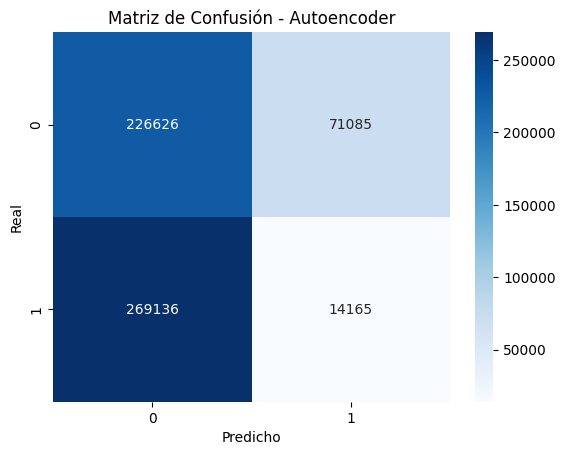

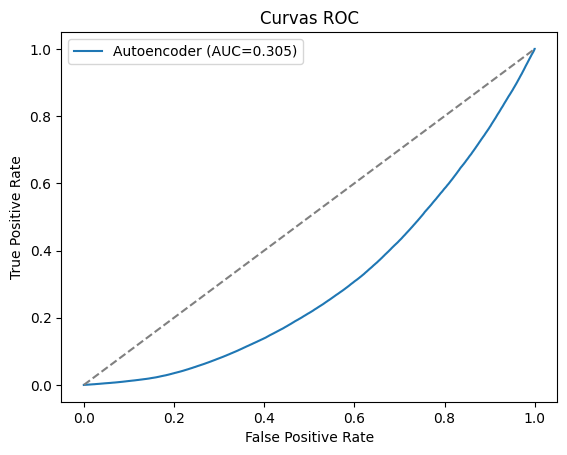

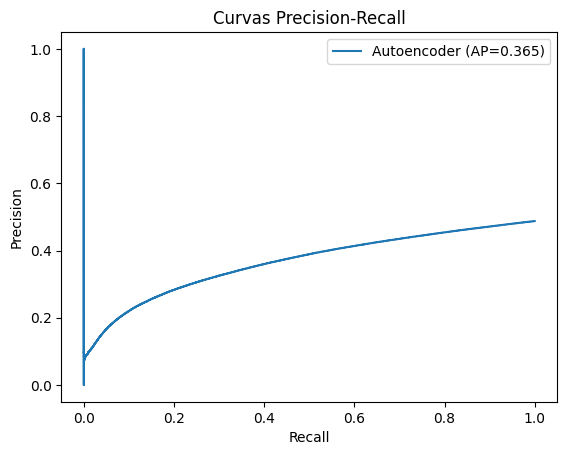

F1 Score @umbral: 0.077
Precision@5%: 0.096

=== Isolation Forest ===


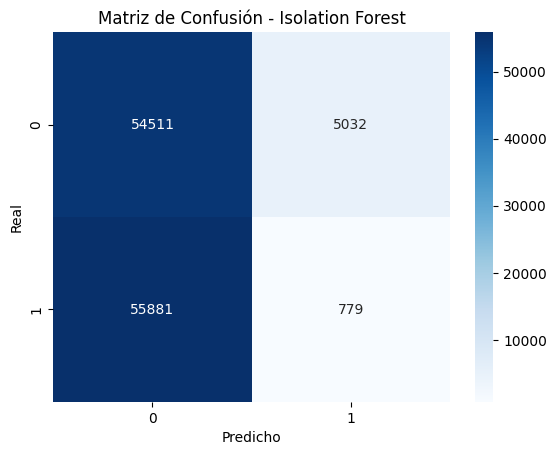

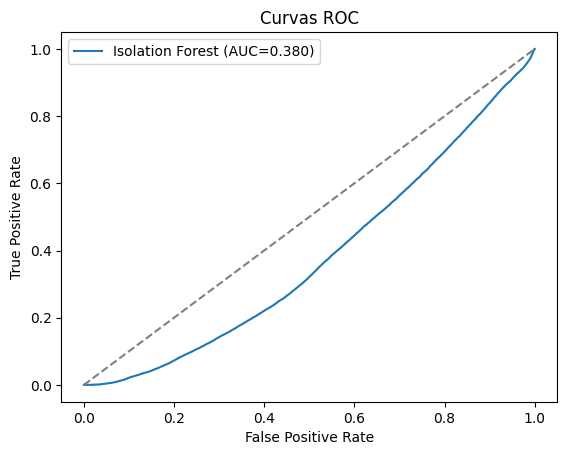

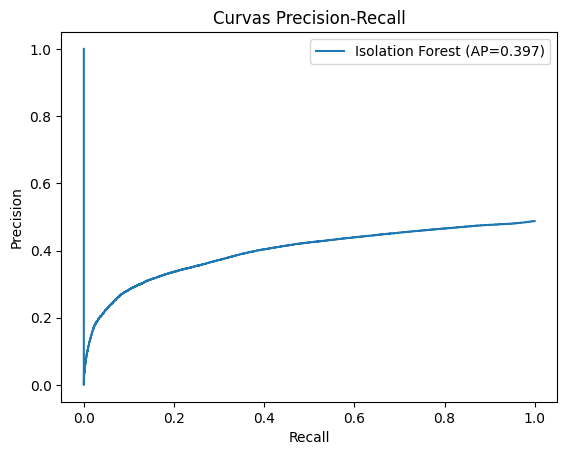

F1 Score @umbral: 0.025
Precision@5%: 0.134

=== Local Outlier Factor ===


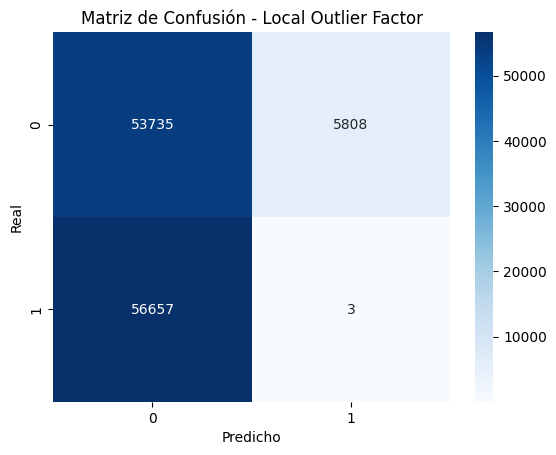

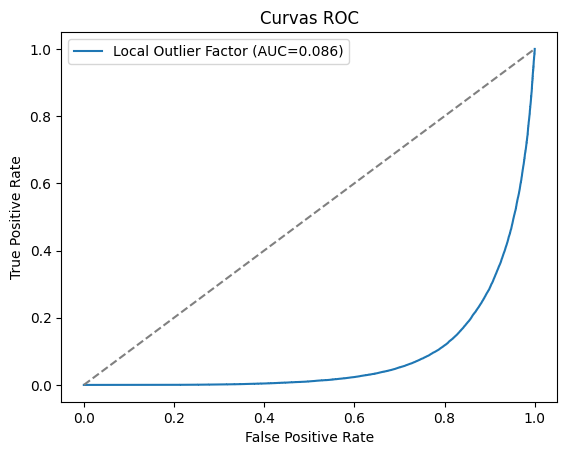

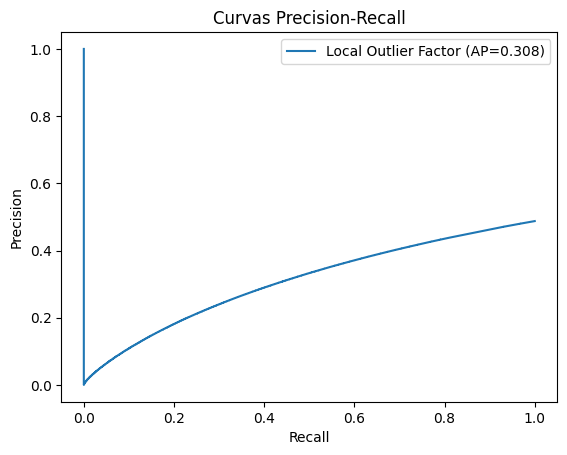

F1 Score @umbral: 0.000
Precision@5%: 0.001


In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import (roc_curve, roc_auc_score, 
                             precision_recall_curve, average_precision_score, 
                             confusion_matrix, f1_score, precision_score)

import seaborn as sns
import numpy as np


# Autoencoder - calcular error de reconstrucción

reconstructions = autoencoder.predict(X_test_ae)
mse = np.mean(np.square(X_test_ae - reconstructions), axis=1)  # error por muestra

# Scores = mayor error → más probable anomalía
scores_ae = mse  

# Selección de umbral (ej: percentil 95 de los normales)
threshold = np.percentile(scores_ae[y_test_ae == 1], 95)
y_pred_ae = (scores_ae > threshold).astype(int)  # 1=anómalo, 0=normal


# Isolation Forest & LOF - decision_function (scores)

# Isolation Forest
scores_iso = -iso_forest.decision_function(X_test_iso)  # invertimos: mayor = más anómalo
y_pred_iso = (scores_iso > np.percentile(scores_iso, 95)).astype(int)

# LOF
scores_lof = -lof.decision_function(X_test_iso)
y_pred_lof = (scores_lof > np.percentile(scores_lof, 95)).astype(int)

# Funciones de evaluación
def evaluate_model(y_true, scores, y_pred, model_name="Model"):
    print(f"\n=== {model_name} ===")
    
    # Matriz de confusión
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Matriz de Confusión - {model_name}")
    plt.xlabel("Predicho")
    plt.ylabel("Real")
    plt.show()
    
    # ROC
    fpr, tpr, _ = roc_curve(y_true, scores)
    auc_roc = roc_auc_score(y_true, scores)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC={auc_roc:.3f})")
    plt.plot([0,1],[0,1],"--",color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Curvas ROC")
    plt.legend()
    plt.show()
    
    # Precision-Recall
    precision, recall, _ = precision_recall_curve(y_true, scores)
    auc_pr = average_precision_score(y_true, scores)
    plt.plot(recall, precision, label=f"{model_name} (AP={auc_pr:.3f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Curvas Precision-Recall")
    plt.legend()
    plt.show()
    
    # F1
    f1 = f1_score(y_true, y_pred)
    print(f"F1 Score @umbral: {f1:.3f}")
    
    # Precision@k (ej: top 5% más anómalos)
    k = int(0.05 * len(scores))
    top_k = np.argsort(scores)[-k:]
    precision_at_k = np.mean(y_true.iloc[top_k])
    print(f"Precision@5%: {precision_at_k:.3f}")


#  Evaluar los tres modelos
evaluate_model(y_test_ae, scores_ae, y_pred_ae, "Autoencoder")
evaluate_model(y_test_iso, scores_iso, y_pred_iso, "Isolation Forest")
evaluate_model(y_test_iso, scores_lof, y_pred_lof, "Local Outlier Factor")
